In [80]:
%load_ext autoreload
%autoreload 2
!pip install plotly

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# Load dữ liệu từ csv (đường dẫn thay bằng file thực tế)
data = pd.read_csv('/content/drive/MyDrive/HocMay_FinalExam/2000-2018.csv')


In [84]:
data

,title,year,avgRating,votes,directorName,writeName,runtime,genre
0,Isle of Dogs,2018,8.2,18140,Wes Anderson,Roman Coppola,101,"Adventure,Animation,Comedy"
1,Isle of Dogs,2018,8.2,18140,Wes Anderson,Kunichi Nomura,101,"Adventure,Animation,Comedy"
2,Isle of Dogs,2018,8.2,18140,Wes Anderson,Wes Anderson,101,"Adventure,Animation,Comedy"
3,Isle of Dogs,2018,8.2,18140,Wes Anderson,Jason Schwartzman,101,"Adventure,Animation,Comedy"
4,A Quiet Place,2018,8.1,68050,John Krasinski,Bryan Woods,90,"Drama,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...
14364,2001: A Space Travesty,2000,3.4,10227,Allan A. Goldstein,Vince Di Clemente,99,"Comedy,Sci-Fi"
14365,2001: A Space Travesty,2000,3.4,10227,Allan A. Goldstein,Alan Shearman,99,"Comedy,Sci-Fi"
14366,Battlefield Earth,2000,2.4,69911,Roger Christian,L. Ron Hubbard,118,"Action,Adventure,Sci-Fi"
14367,Battlefield Earth,2000,2.4,69911,Roger Christian,Corey Mandell,118,"Action,Adventure,Sci-Fi"


In [85]:
  data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14369 entries, 0 to 14368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         14369 non-null  object 
 1   year          14369 non-null  int64  
 2   avgRating     14369 non-null  float64
 3   votes         14369 non-null  int64  
 4   directorName  14369 non-null  object 
 5   writeName     14369 non-null  object 
 6   runtime       14369 non-null  int64  
 7   genre         14369 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 898.2+ KB


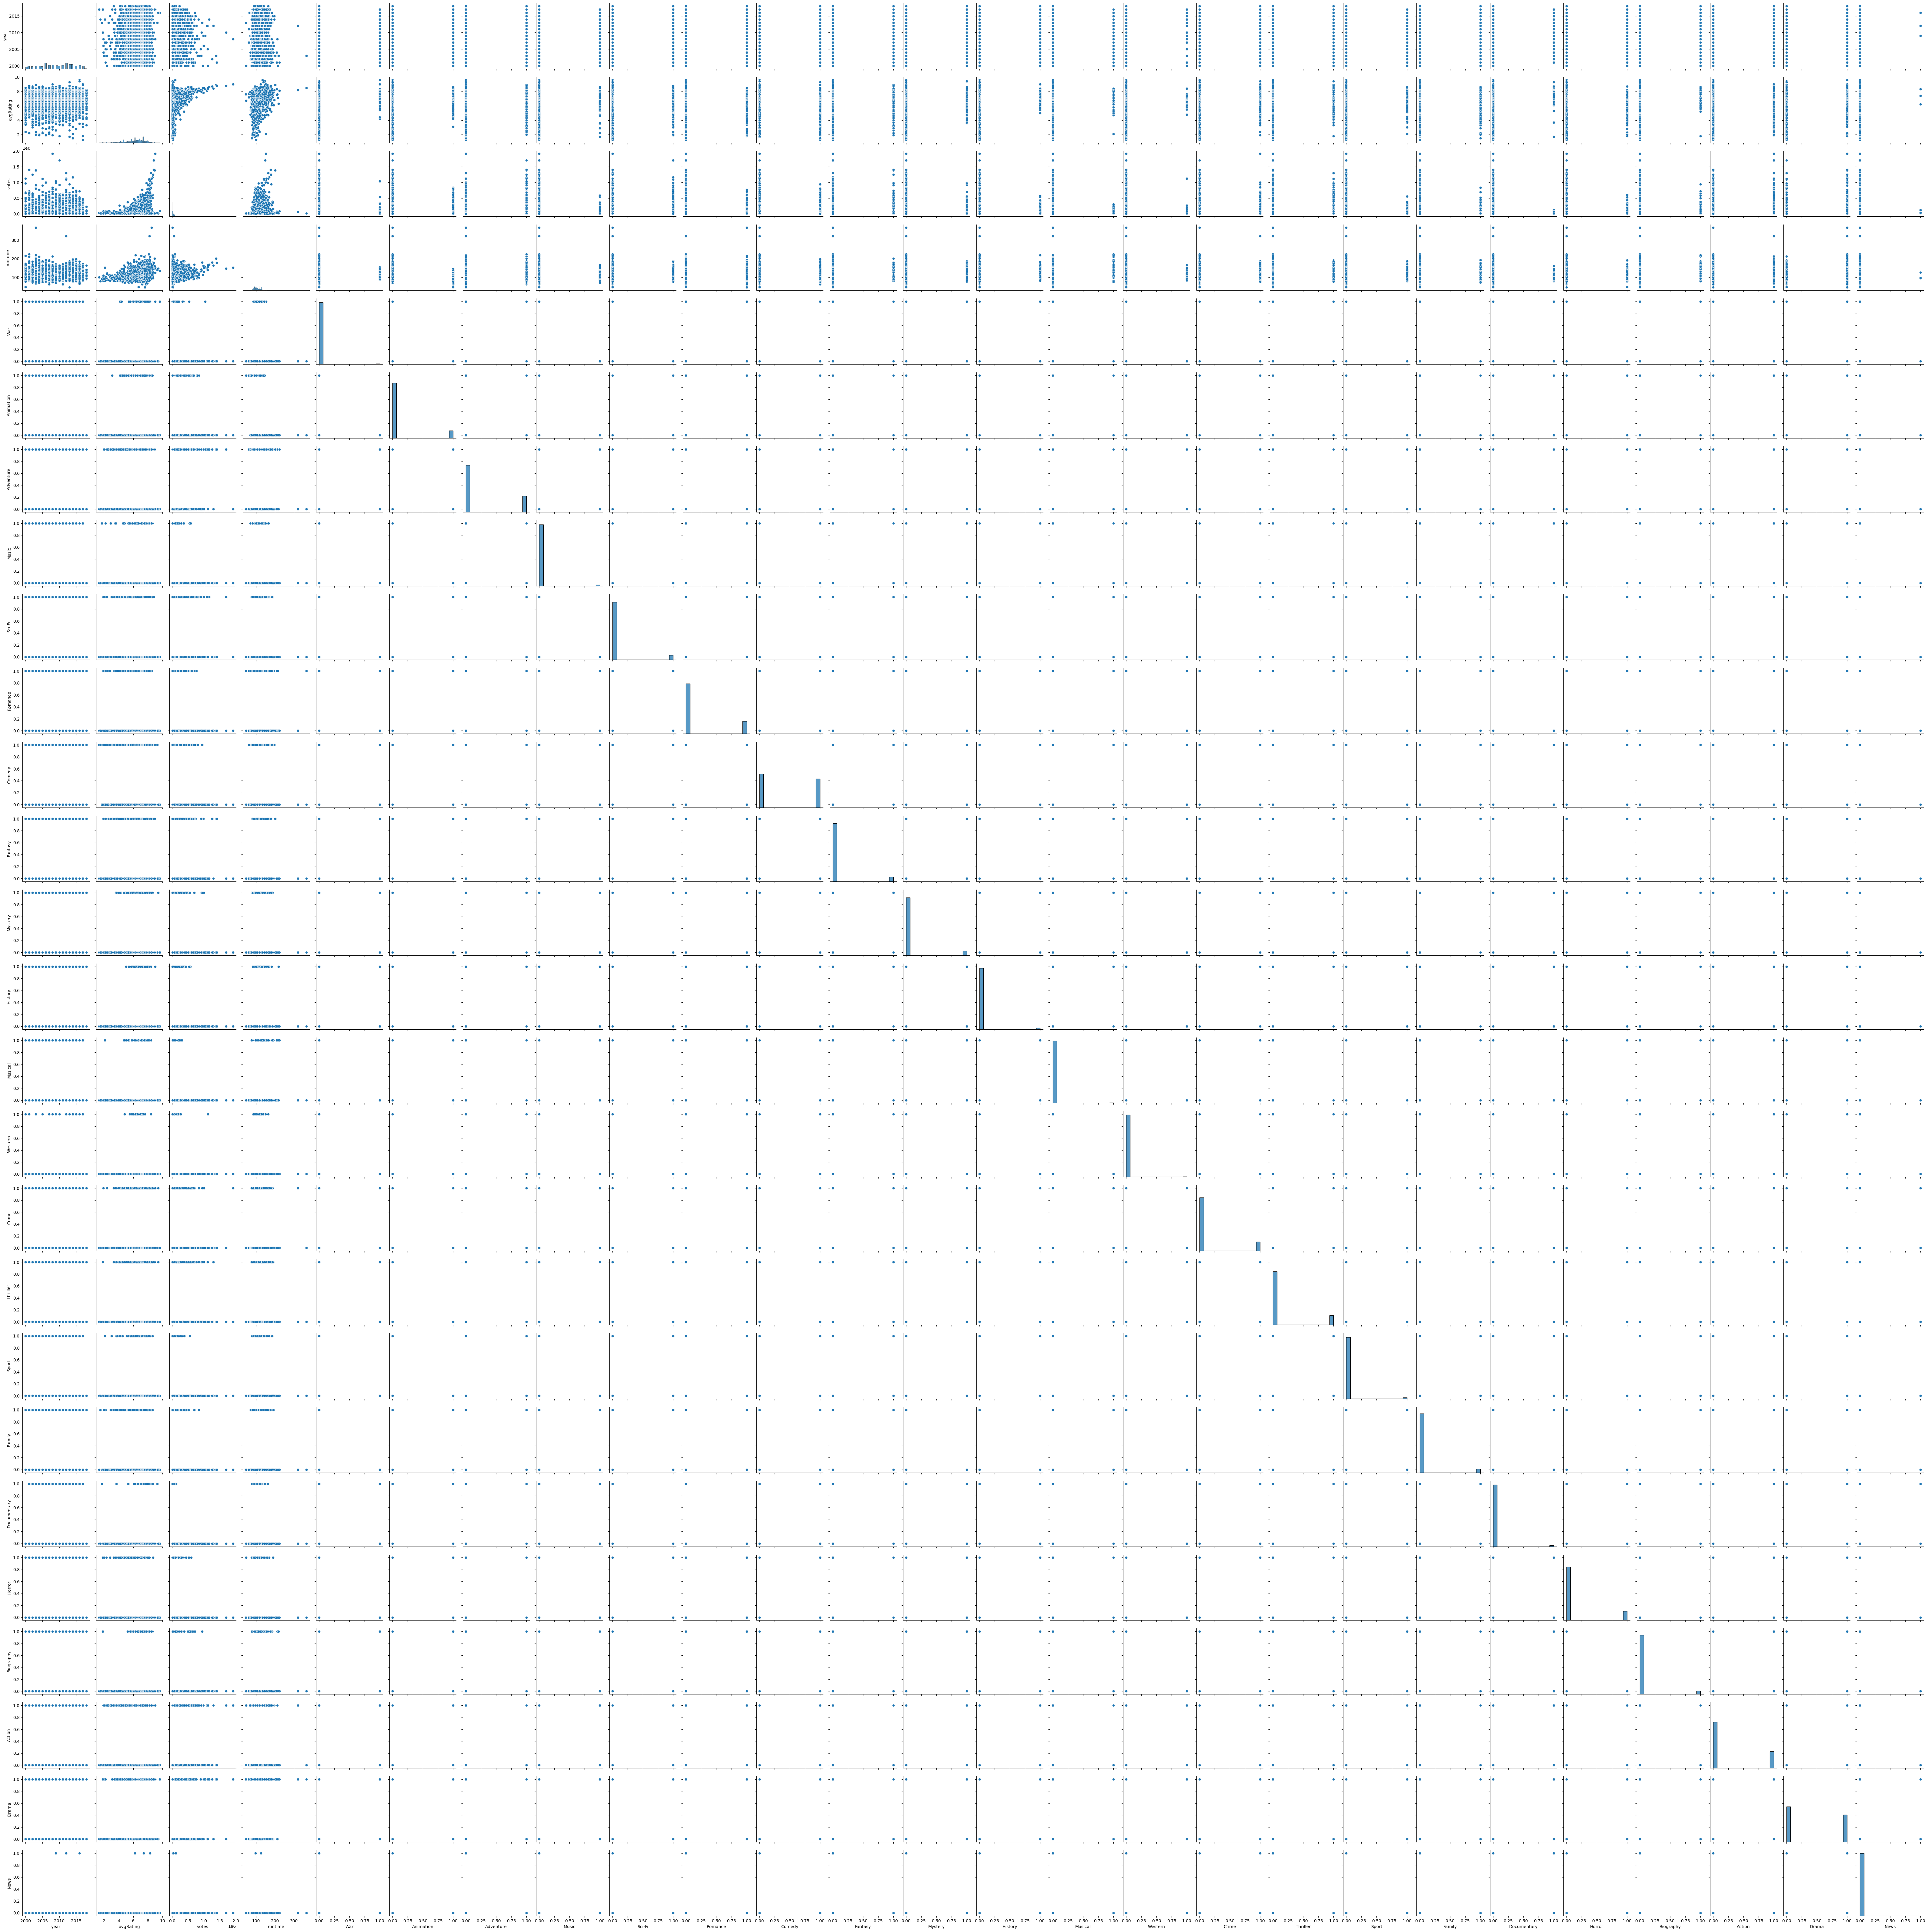

In [ ]:
sns.pairplot(data)

In [ ]:
sns.pairplot(data, hue='avgRating')

Output hidden; open in https://colab.research.google.com to view.

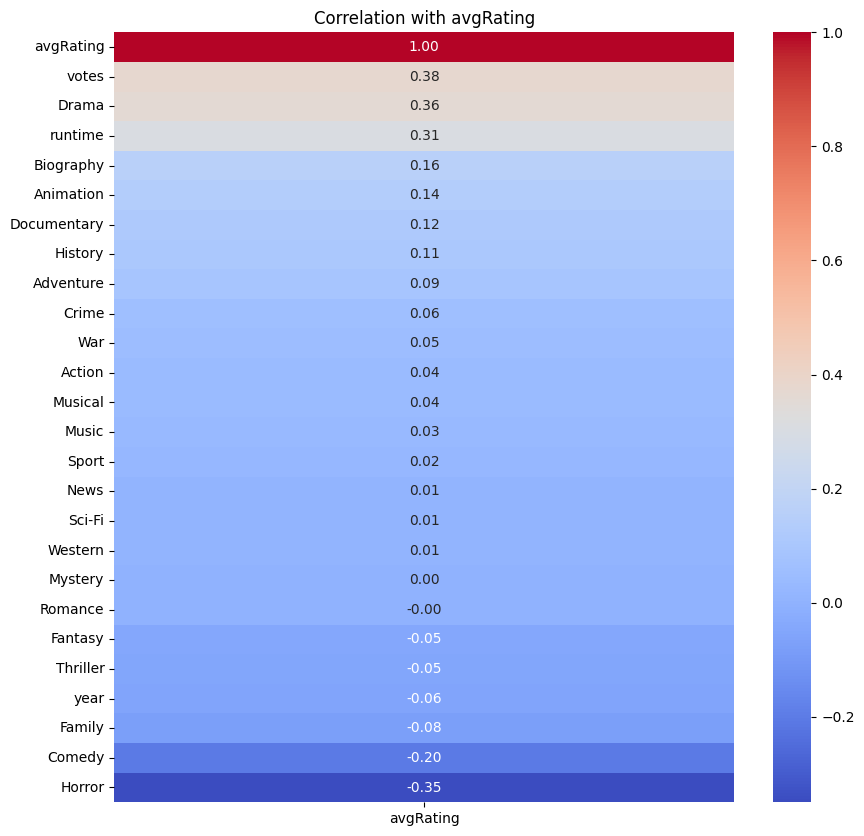

In [86]:
plt.figure(figsize=(10, 10))
cor_target = cor[["avgRating"]].sort_values(by="avgRating", ascending=False)
sns.heatmap(cor_target, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with avgRating")
plt.show()


In [87]:
# Chuyển đổi cột số và xử lý giá trị thiếu
data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
data['year'] = pd.to_numeric(data['year'], errors='coerce')
data['votes'] = pd.to_numeric(data['votes'], errors='coerce')
data['avgRating'] = pd.to_numeric(data['avgRating'], errors='coerce')

In [88]:
# Xóa các hàng thiếu giá trị ở cột mục tiêu hoặc cột số chính
print("Columns before dropna:", data.columns.tolist()) # Print column names as a list
data = data.dropna(subset=['avgRating', 'runtime', 'year', 'votes'])
print("Columns after dropna:", data.columns.tolist()) # Print column names as a list


Columns before dropna: ['title', 'year', 'avgRating', 'votes', 'directorName', 'writeName', 'runtime', 'genre']
Columns after dropna: ['title', 'year', 'avgRating', 'votes', 'directorName', 'writeName', 'runtime', 'genre']


In [89]:
print(data.columns)


Index(['title', 'year', 'avgRating', 'votes', 'directorName', 'writeName',
       'runtime', 'genre'],
      dtype='object')


In [90]:
data[["genre_1","genre_2","genre_3"]] = data['genre'].str.split(',', n = 3, expand=True)
data = data.drop(['genre'], axis=1)

In [91]:
data.head()

,title,year,avgRating,votes,directorName,writeName,runtime,genre_1,genre_2,genre_3
0,Isle of Dogs,2018,8.2,18140,Wes Anderson,Roman Coppola,101,Adventure,Animation,Comedy
1,Isle of Dogs,2018,8.2,18140,Wes Anderson,Kunichi Nomura,101,Adventure,Animation,Comedy
2,Isle of Dogs,2018,8.2,18140,Wes Anderson,Wes Anderson,101,Adventure,Animation,Comedy
3,Isle of Dogs,2018,8.2,18140,Wes Anderson,Jason Schwartzman,101,Adventure,Animation,Comedy
4,A Quiet Place,2018,8.1,68050,John Krasinski,Bryan Woods,90,Drama,Horror,Sci-Fi


In [92]:
data['genre_1'] = data['genre_1'].str.replace(' ', '')
data['genre_2'] = data['genre_2'].str.replace(' ', '')
data['genre_3'] = data['genre_3'].str.replace(' ', '')


In [93]:
# Lấy danh sách thể loại duy nhất
l1 = data.genre_1.unique()
l2 = data.genre_2.unique()
l3 = data.genre_3.unique()
all_genres = list(l1) + list(l2) + list(l3)
all_genres = [g for g in all_genres if pd.notna(g) and g != '']
all_genres = list(set(all_genres))


In [94]:
len(all_genres)

22

In [95]:
# Tạo cột one-hot cho từng thể loại, khởi tạo bằng 0
for genre in all_genres:
    data[genre] = 0

# Gán giá trị 1 nếu thể loại có trong 1 trong 3 cột genre_1,2,3
for idx, row in data.iterrows():
    for genre in all_genres:
        if (row['genre_1'] == genre) or (row['genre_2'] == genre) or (row['genre_3'] == genre):
            data.at[idx, genre] = 1

In [96]:
data.head()

,title,year,avgRating,votes,directorName,writeName,runtime,genre_1,genre_2,genre_3,...,Crime,Thriller,Sport,Family,Documentary,Horror,Biography,Action,Drama,News
0,Isle of Dogs,2018,8.2,18140,Wes Anderson,Roman Coppola,101,Adventure,Animation,Comedy,...,0,0,0,0,0,0,0,0,0,0
1,Isle of Dogs,2018,8.2,18140,Wes Anderson,Kunichi Nomura,101,Adventure,Animation,Comedy,...,0,0,0,0,0,0,0,0,0,0
2,Isle of Dogs,2018,8.2,18140,Wes Anderson,Wes Anderson,101,Adventure,Animation,Comedy,...,0,0,0,0,0,0,0,0,0,0
3,Isle of Dogs,2018,8.2,18140,Wes Anderson,Jason Schwartzman,101,Adventure,Animation,Comedy,...,0,0,0,0,0,0,0,0,0,0
4,A Quiet Place,2018,8.1,68050,John Krasinski,Bryan Woods,90,Drama,Horror,Sci-Fi,...,0,0,0,0,0,1,0,0,1,0


(np.float64(22.0), np.float64(0.0))

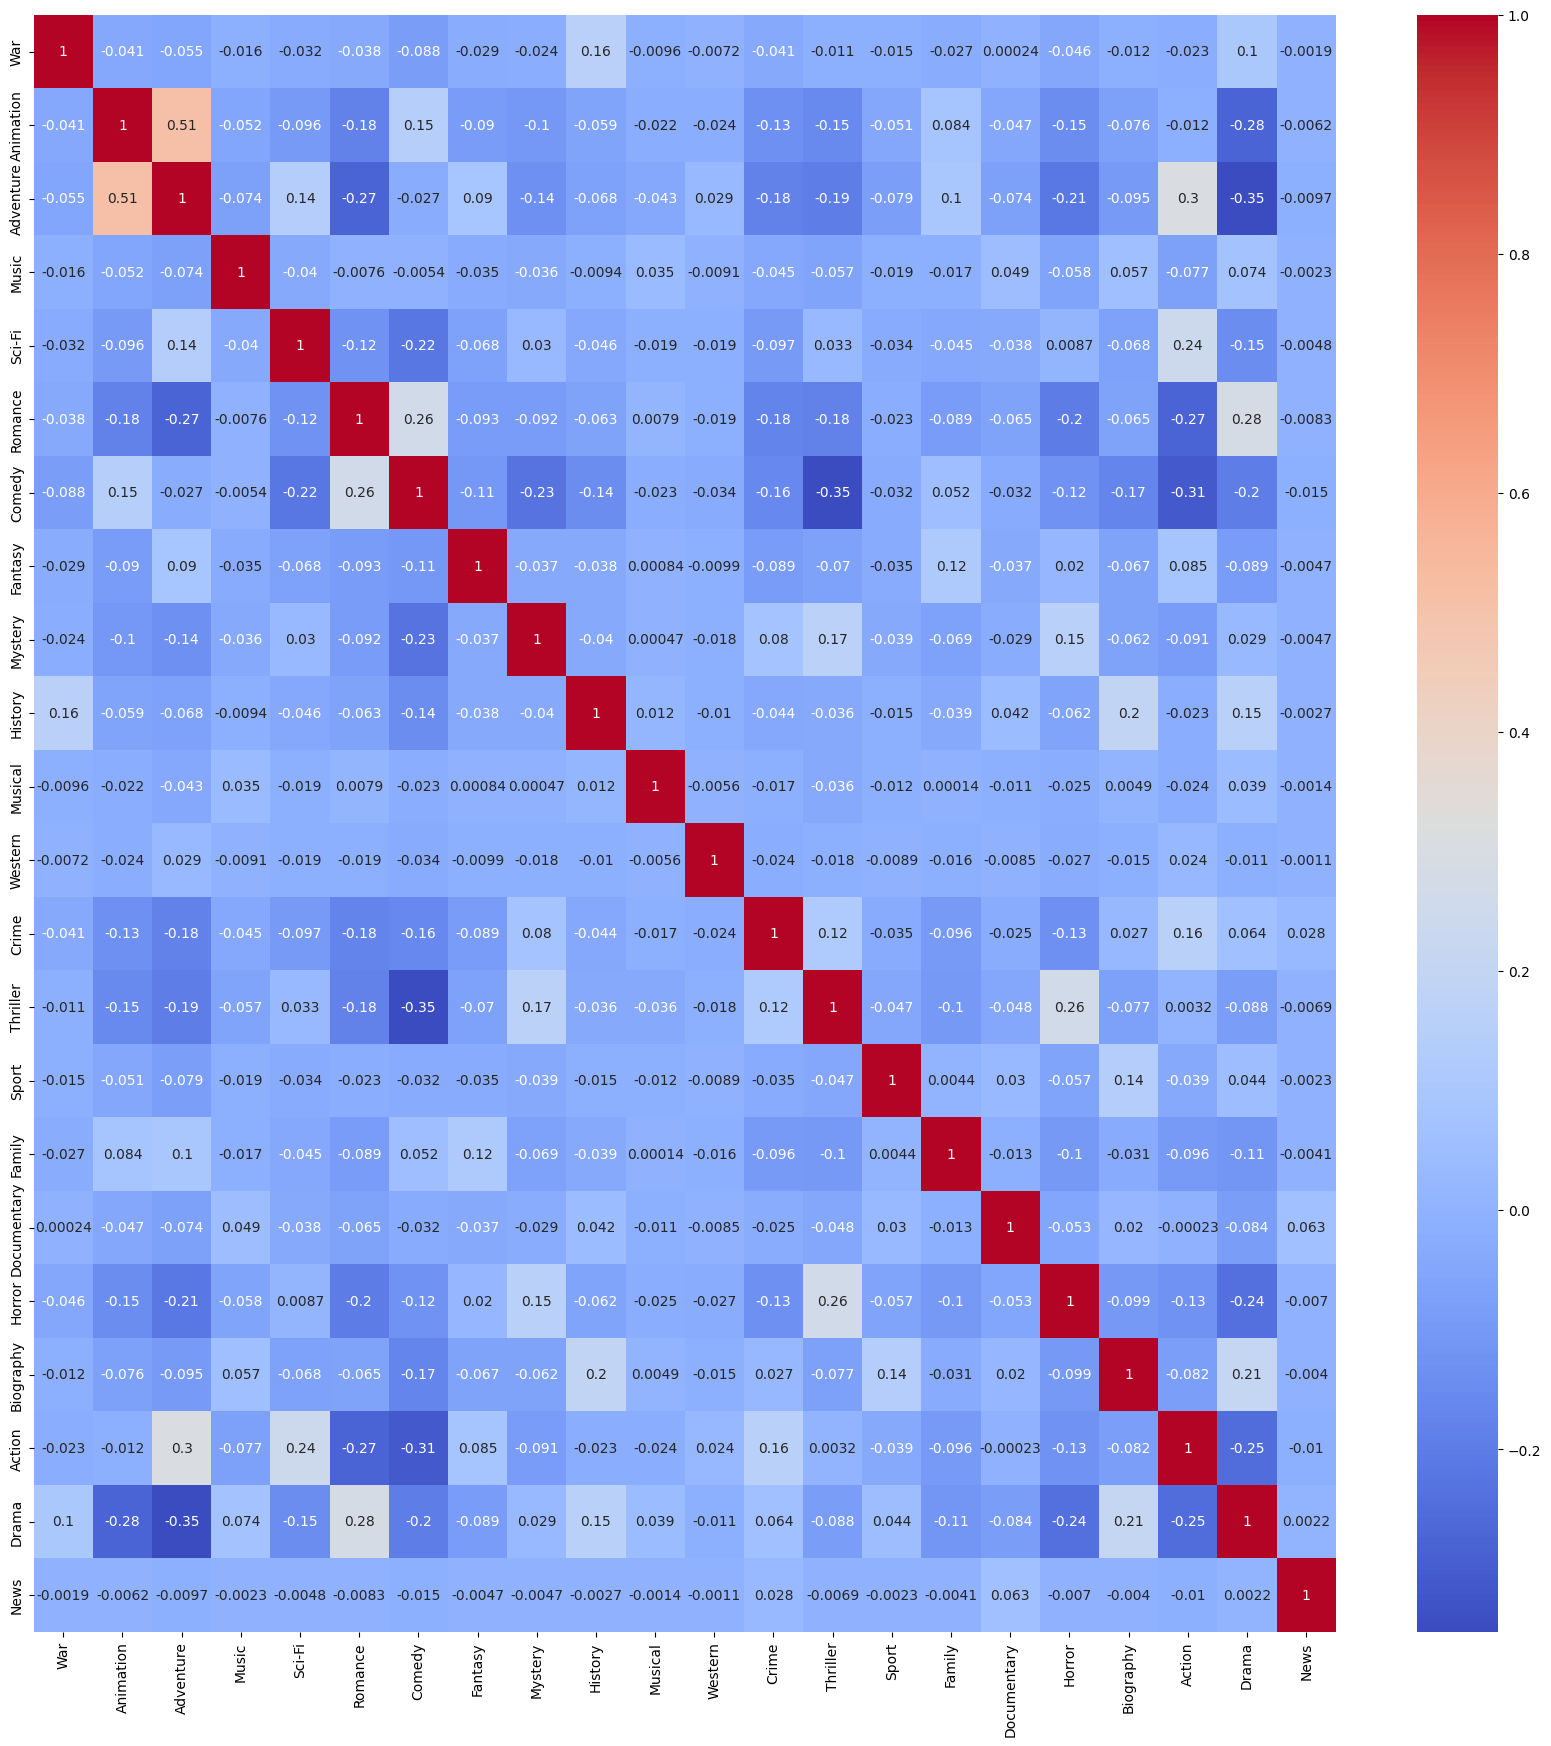

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(21,21))
# Changed 'l' to 'all_genres' to use the list of genre columns
cor = data[all_genres].corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.ylim()

In [98]:
# Chuẩn bị dữ liệu cho model
categorical_columns = ['directorName', 'writeName']
numerical_columns = ['runtime', 'year', 'votes']
genre_columns = all_genres

X = data[categorical_columns + numerical_columns + genre_columns]
y = data['avgRating']

In [99]:
# Pipeline tiền xử lý
from sklearn.preprocessing import StandardScaler # Import StandardScaler

categorical_pipeline = OneHotEncoder(handle_unknown='ignore') # Removed sparse=False
numerical_pipeline = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_columns),
    ('num', numerical_pipeline, numerical_columns),
    ('genre', 'passthrough', genre_columns)  # genre đã one-hot rồi
])

In [102]:
print(genre_columns)

['War', 'Animation', 'Adventure', 'Music', 'Sci-Fi', 'Romance', 'Comedy', 'Fantasy', 'Mystery', 'History', 'Musical', 'Western', 'Crime', 'Thriller', 'Sport', 'Family', 'Documentary', 'Horror', 'Biography', 'Action', 'Drama', 'News']


In [103]:
# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [104]:
# Pipeline mô hình với RandomForest
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# GridSearch để tìm tham số tốt nhất
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}

from sklearn.model_selection import GridSearchCV # Import GridSearchCV

grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best CV RMSE: 0.4234500695921389


In [105]:
# 8. Dự đoán & đánh giá
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))


Train RMSE: 0.1412964597537037
Train R2: 0.9829297138392283
Test RMSE: 0.39715453512938065
Test R2: 0.8612800593123128


In [ ]:
# Train RMSE: 0.1590867313190347
# Train R2: 0.9783605530134307
# Test RMSE: 0.4388186089635684
# Test R2: 0.83064816181028

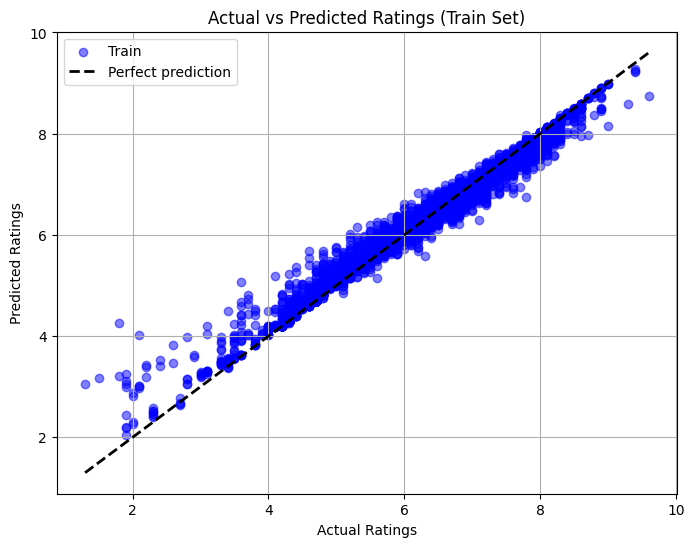

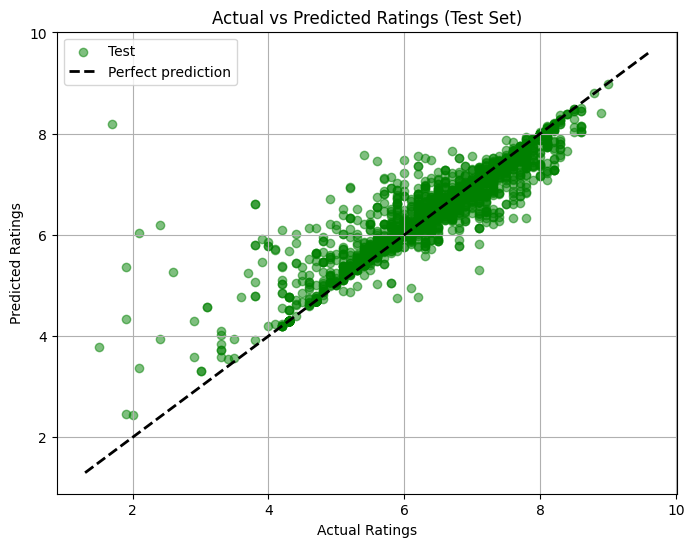

In [106]:
import matplotlib.pyplot as plt

# Biểu đồ tập huấn luyện
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, alpha=0.5, label='Train', color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect prediction')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Train Set)")
plt.legend()
plt.grid(True)
plt.show()

# Biểu đồ tập kiểm tra
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, label='Test', color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect prediction')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [107]:
import pandas as pd

# Dự đoán trên tập test
y_pred_test = best_model.predict(X_test)

# Tạo DataFrame so sánh giá trị thực tế và dự đoán
df_compare = pd.DataFrame({
    'Actual_IMDb_Rating': y_test,
    'Predicted_IMDb_Rating': y_pred_test
})

# Hiển thị 10 dòng đầu để đánh giá trực quan
print(df_compare.head(10))

# Hoặc hiển thị giá trị thực và dự đoán một cách có định dạng dễ đọc hơn
for actual, pred in zip(y_test[:10], y_pred_test[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")


       Actual_IMDb_Rating  Predicted_IMDb_Rating
12001                 6.0                 6.0000
8978                  7.3                 7.2440
9646                  7.6                 6.8270
14145                 6.6                 6.5930
3751                  6.1                 6.1000
13185                 5.9                 6.7195
4149                  4.3                 4.3000
3704                  6.2                 6.5380
7741                  5.5                 5.5270
2859                  6.2                 6.1630
Actual: 6.00, Predicted: 6.00
Actual: 7.30, Predicted: 7.24
Actual: 7.60, Predicted: 6.83
Actual: 6.60, Predicted: 6.59
Actual: 6.10, Predicted: 6.10
Actual: 5.90, Predicted: 6.72
Actual: 4.30, Predicted: 4.30
Actual: 6.20, Predicted: 6.54
Actual: 5.50, Predicted: 5.53
Actual: 6.20, Predicted: 6.16


In [110]:
import joblib

# Lưu mô hình tốt nhất đã huấn luyện
joblib.dump(best_model, '/content/drive/MyDrive/HocMay_FinalExam/model.pkl')


['/content/drive/MyDrive/HocMay_FinalExam/model.pkl']

In [109]:
# Lưu danh sách thể loại phim
joblib.dump(all_genres, '/content/drive/MyDrive/HocMay_FinalExam/genres.pkl')


['/content/drive/MyDrive/HocMay_FinalExam/genres.pkl']